In [101]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Conv2DTranspose,Input,Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

import os
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [102]:
import cv2
import PIL
from keras import backend
#from random import randint
from google.colab import files
import glob

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
train_start_index = 0
train_end_index = 600

test_start_index = 600
test_end_index = 900

In [105]:
dirname="/content/drive/MyDrive/dataset/complete/";
#use 300s dataset - dirname="/content/drive/MyDrive/colab/dataset/Resized/complete/";

files=['rectangle/']
labels=[1]



In [106]:
import re 
import math
from pathlib import Path 

file_pattern = re.compile(r'.*?(\d+).*?')
def get_order(file):
    match = file_pattern.match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

sorted_files = sorted(files, key=get_order)


In [107]:
import os
def sortKeyFunc(s):
    return int(os.path.basename(s)[:-4])


In [108]:
images=[]
y=[]

for i in range(len(files)):
    cfiles=glob.glob(dirname+files[i]+'*.jpg')
    cfiles.sort(key=sortKeyFunc)
    
    for cf in cfiles:
        img=cv2.imread(cf)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        (thresh, imw) = cv2.threshold(img, 1, 1, 1)
        contours, _ = cv2.findContours(imw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            rect = cv2.boundingRect(c)
            # if rect[2] < 100 or rect[3] < 100: 
            #   continue
            x11,y11,w11,h11 = rect
            # cv2.rectangle(img,(x11,y11),(x11+w11,y11+h11),(0,255,0),2)
        a11=x11
        b11=y11
        c11=x11+w11
        d11=y11+h11
        cropped_image = img[b11:d11 , a11:c11]
        newimg=cv2.resize(cropped_image, (28, 28))
        images.append(newimg)
        y.append(labels[i])

In [109]:
X=np.array(images)
y=np.array(y)
print(X.shape)
print(y.shape)

(900, 28, 28)
(900,)


In [110]:
dirname2="/content/drive/MyDrive/dataset/partial/";
#use 300s dataset - dirname2="/content/drive/MyDrive/colab/dataset/Resized/partial/";

images2=[]
y2=[]
for i in range(len(files)):
    cfiles=glob.glob(dirname2+files[i]+'*.jpg')
    cfiles.sort(key=sortKeyFunc)
    
    for cf in cfiles:
        img=cv2.imread(cf)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        (thresh, imw) = cv2.threshold(img, 1, 1, 1)
        contours, _ = cv2.findContours(imw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            rect = cv2.boundingRect(c)
            # if rect[2] < 100 or rect[3] < 100: 
            #   continue
            x11,y11,w11,h11 = rect
            # cv2.rectangle(img,(x11,y11),(x11+w11,y11+h11),(0,255,0),2)
        a11=x11
        b11=y11
        c11=x11+w11
        d11=y11+h11
        cropped_image = img[b11:d11 , a11:c11]
        newimg=cv2.resize(cropped_image, (28, 28))
        images2.append(newimg)
        y2.append(labels[i])
X2=np.array(images2)
y2=np.array(y2)
print(X2.shape)
print(y2.shape)

(900, 28, 28)
(900,)


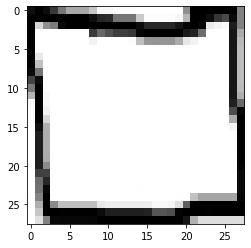

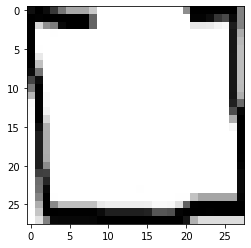

In [111]:
fig = plt.figure
plt.imshow(X[1], cmap='gray')
plt.show()
plt.imshow(X2[1], cmap='gray')
plt.show()

In [112]:
# define leaky ReLU function
def lrelu(x, alpha=0.1):
    return tf.math.maximum(alpha*x, x)

In [113]:
training_set=[]
train_lev=[]
for i in range(train_start_index, train_end_index):
  training_set.append(X[i])
  train_lev.append(y[i])
  train_imgs=np.array(training_set)
  train_labels=np.array(train_lev)
print(train_imgs.shape)
print(train_labels.shape)  

testing_set=[]
test_lev=[]
for i in range(test_start_index,test_end_index):
  testing_set.append(X[i])
  test_lev.append(y[i])
  test_imgs=np.array(testing_set)
  test_labels=np.array(test_lev)
print(test_imgs.shape)   
print(test_labels.shape)

(600, 28, 28)
(600,)
(300, 28, 28)
(300,)


In [114]:
train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0 
print(train_imgs.shape)

(600, 28, 28)


In [115]:
# check data array shapes:
print("Size of train images: {}, Number of train images: {}".format(train_imgs.shape[-2:], train_imgs.shape[0]))
print("Size of test images: {}, Number of test images: {}".format(test_imgs.shape[-2:], test_imgs.shape[0]))

Size of train images: (28, 28), Number of train images: 600
Size of test images: (28, 28), Number of test images: 300


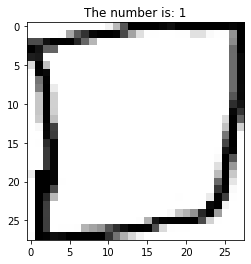

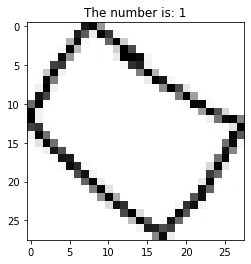

In [116]:
# plot distorted image example from training images
image_id_to_plot = 20
plt.imshow(tf.squeeze(train_imgs[image_id_to_plot]), cmap='gray')
plt.title("The number is: {}".format(train_labels[image_id_to_plot]))
plt.show()

# plot distorted image example from test images
plt.imshow(tf.squeeze(test_imgs[image_id_to_plot]), cmap='gray')
plt.title("The number is: {}".format(test_labels[image_id_to_plot]))
plt.show()
plt.close()

In [117]:
num_pixels = 28*28
train_imgs = train_imgs.reshape((train_end_index-train_start_index), num_pixels).astype('float32')
test_imgs = test_imgs.reshape((test_end_index-test_start_index), num_pixels).astype('float32')
print(train_imgs.shape)

(600, 784)


In [118]:
# load mnist dataset
#(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.mnist.load_data()

# fit image pixel values from 0 to 1
#train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0 


In [119]:
# prepare training reference images: add new dimension
#train_imgs_data = train_imgs[..., tf.newaxis]
# prepare test reference images: add new dimension
#test_imgs_data = test_imgs[..., tf.newaxis]

In [120]:
# add noise to the images for train and test cases
#def distort_image(input_imgs, noise_factor=0.5):
#    noisy_imgs = input_imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=input_imgs.shape) 
#    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
#    return noisy_imgs

# prepare distorted input data for training
#train_noisy_imgs = distort_image(train_imgs_data)

# prepare distorted input data for evaluation
#test_noisy_imgs = distort_image(test_imgs_data)

In [121]:
training_partial_set=[]
train_partial_lev=[]
for i in range(train_start_index,train_end_index):
  training_partial_set.append(X2[i])
  train_partial_lev.append(y2[i])
  train_partial_imgs=np.array(training_partial_set)
  train_partial_labels=np.array(train_partial_lev)
print(train_partial_imgs.shape)
print(train_partial_labels.shape)  

testing_partial_set=[]
test_partial_lev=[]
for i in range(test_start_index,test_end_index):
  testing_partial_set.append(X2[i])
  test_partial_lev.append(y2[i])
  test_partial_imgs=np.array(testing_partial_set)
  test_partial_labels=np.array(test_partial_lev)
print(test_partial_imgs.shape)   
print(test_partial_labels.shape)

(600, 28, 28)
(600,)
(300, 28, 28)
(300,)


In [122]:
num_pixels = 28*28
train_partial_imgs = train_partial_imgs.reshape((train_end_index-train_start_index), num_pixels).astype('float32')
test_partial_imgs = test_partial_imgs.reshape((test_end_index-test_start_index), num_pixels).astype('float32')
print(train_imgs.shape)

(600, 784)


In [ ]:
# plot distorted image example from training images
image_id_to_plot = 20
plt.imshow(tf.squeeze(train_partial_imgs[image_id_to_plot]), cmap='gray')
plt.title("The number is: {}".format(train_partial_labels[image_id_to_plot]))
plt.show()

# plot distorted image example from test images
plt.imshow(tf.squeeze(test_partial_imgs[image_id_to_plot]), cmap='gray')
plt.title("The number is: {}".format(test_partial_labels[image_id_to_plot]))
plt.show()
plt.close()

In [123]:
enco_deco = Sequential()
# Encoder
enco_deco.add(Dense(500, input_dim=num_pixels, activation='LeakyReLU'))
enco_deco.add(Dense(300, activation='LeakyReLU'))
enco_deco.add(Dense(300, activation='LeakyReLU'))
enco_deco.add(Dense(100, activation='LeakyReLU'))
 
#decoder
enco_deco.add(Dense(300, activation='LeakyReLU'))
enco_deco.add(Dense(500, activation='LeakyReLU'))
enco_deco.add(Dense(784, activation='sigmoid'))
enco_deco.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 500)               392500    
                                                                 
 dense_22 (Dense)            (None, 300)               150300    
                                                                 
 dense_23 (Dense)            (None, 300)               90300     
                                                                 
 dense_24 (Dense)            (None, 100)               30100     
                                                                 
 dense_25 (Dense)            (None, 300)               30300     
                                                                 
 dense_26 (Dense)            (None, 500)               150500    
                                                                 
 dense_27 (Dense)            (None, 784)              

In [124]:
def cost_function(labels=None, logits=None, name=None):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits, name=name)
    return tf.reduce_mean(loss)
learning_rate = 1e-5    
enco_deco.compile(optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),loss=cost_function,metrics=None)
#enco_deco.compile(loss='mean_squared_error', optimizer='adam')



In [125]:
histry=enco_deco.fit(train_partial_imgs, train_imgs, validation_data=(test_partial_imgs, test_imgs), epochs=1000,
                     workers=1,batch_size=300, shuffle=True)


Epoch 1/1000
2/2 [==============================] - 1s 227ms/step - loss: 0.6188 - val_loss: 0.6040
Epoch 2/1000
2/2 [==============================] - 0s 96ms/step - loss: 0.6160 - val_loss: 0.6019
Epoch 3/1000
2/2 [==============================] - 0s 130ms/step - loss: 0.6133 - val_loss: 0.5999
Epoch 4/1000
2/2 [==============================] - 0s 103ms/step - loss: 0.6108 - val_loss: 0.5980
Epoch 5/1000
2/2 [==============================] - 0s 113ms/step - loss: 0.6086 - val_loss: 0.5964
Epoch 6/1000
2/2 [==============================] - 0s 109ms/step - loss: 0.6066 - val_loss: 0.5950
Epoch 7/1000
2/2 [==============================] - 0s 97ms/step - loss: 0.6047 - val_loss: 0.5938
Epoch 8/1000
2/2 [==============================] - 0s 108ms/step - loss: 0.6029 - val_loss: 0.5928
Epoch 9/1000
2/2 [==============================] - 0s 102ms/step - loss: 0.6011 - val_loss: 0.5917
Epoch 10/1000
2/2 [==============================] - 0s 102ms/step - loss: 0.5994 - val_loss: 0.5907
E

In [126]:
predictions = enco_deco.predict(test_partial_imgs)
print("prediction set", predictions.shape)

10/10 [==============================] - 0s 5ms/step
prediction set (300, 784)


Train images


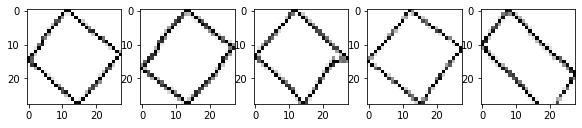

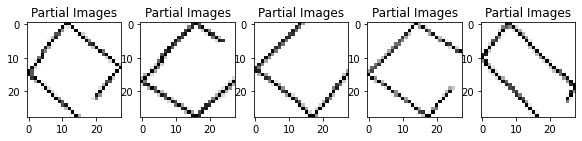

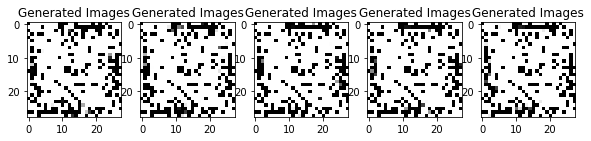

In [127]:
X_test = np.reshape(test_imgs, ((test_end_index-test_start_index),28,28)) *255
plt.figure(figsize=(20, 4))
print("Train images")
for i in range(5,10,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i,:,:], cmap='gray')
plt.show()
 
x_test_noisy = np.reshape(test_partial_imgs, (-1,28,28)) *255
plt.figure(figsize=(20, 4))
for i in range(5,10,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i,:,:], cmap='gray')
    plt.title("Partial Images")
plt.show()    
 
prediction = np.reshape(predictions, ((test_end_index-test_start_index),28,28)) *255
plt.figure(figsize=(20, 4))
for i in range(5,10,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(prediction[i,:,:], cmap='gray')
    plt.title("Generated Images")  
plt.show()

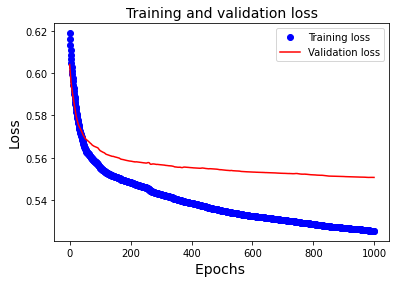

In [128]:
# funstion for train and val losses visualizations
def plot_losses(results):
    plt.plot(results.history['loss'], 'bo', label='Training loss')
    plt.plot(results.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss',fontsize=14)
    plt.xlabel('Epochs ',fontsize=14)
    plt.ylabel('Loss',fontsize=14)
    plt.legend()
    plt.show()
    plt.close()

# visualize train and val losses
plot_losses(histry)